# CNN classification on melspectograms for native language identification

This approach is taken from this [article](https://medium.com/@hasithsura/audio-classification-d37a82d6715).
We use different approaches:
 - Train a CNN from scratch.
 - Retrained a pretrained ResNet34.
 - Augment data by partitioning the 45 second utterances into 5 second utterances.

In [30]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score

In [2]:
folder_path = 'C:/native_language/wav/'

In [3]:
wav, sr = librosa.load(folder_path+'train_0001.wav', sr=None)
print(f'Sampling rate of the audio is {sr} Hz and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 16000 Hz and length of the audio is 46.8 seconds


In [4]:
wav.shape

(748800,)

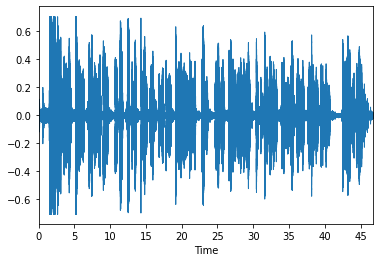

In [5]:
librosa.display.waveplot(wav, sr)

In [6]:
class CNN(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_cats=11):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [7]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [8]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=64, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)

    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[2*sr:20*sr]
        spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                                            hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
        spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

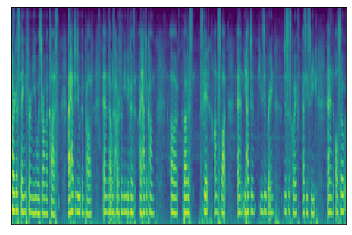

In [9]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(folder_path+'train_0001.wav', sr)), cmap='viridis')

In [10]:
spec_to_image(get_melspectrogram_db(folder_path+'train_0001.wav', sr)).shape

(64, 563)

In [11]:
label_file = "C:/native_language/lab/ComParE2016_Nativeness.tsv"

In [12]:
data_file = pd.read_csv(label_file, sep="\t")
data_file.tail()

,file_name,promptId,L1
4260,devel_0961.wav,P7,CHI
4261,devel_0962.wav,P7,FRE
4262,devel_0963.wav,P7,GER
4263,devel_0964.wav,P6,FRE
4264,devel_0965.wav,P5,GER


In [13]:
train_files = data_file['file_name'].str.contains('train')
train_df = data_file[train_files]
train_df.tail()

,file_name,promptId,L1
3295,train_3296.wav,P1,TEL
3296,train_3297.wav,P2,TUR
3297,train_3298.wav,P7,SPA
3298,train_3299.wav,P1,CHI
3299,train_3300.wav,P5,KOR


In [14]:
dev_files = data_file['file_name'].str.contains('devel')
dev_df = data_file[dev_files]
dev_df.tail()

,file_name,promptId,L1
4260,devel_0961.wav,P7,CHI
4261,devel_0962.wav,P7,FRE
4262,devel_0963.wav,P7,GER
4263,devel_0964.wav,P6,FRE
4264,devel_0965.wav,P5,GER


In [15]:
len(train_df), len(dev_df)

(3300, 965)

In [16]:
class Data(Dataset):
    def __init__(self, df, base='C:/native_language/wav/', in_col='file_name', out_col='L1'):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category

        for ind in range(len(df)):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            label = row[out_col]
            self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            self.labels.append(self.c2i[row[out_col]])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [17]:
train_data = Data(train_df, base='C:/native_language/wav/',
                  in_col='file_name', out_col='L1')

In [18]:
dev_data = Data(dev_df, base='C:/native_language/wav/',
                  in_col='file_name', out_col='L1')

In [ ]:
BATCH_SIZE = 32

In [19]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dev_data, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [21]:
n_cats = 11
model = CNN(input_shape=(1, 64, 563), batch_size=BATCH_SIZE, 
            num_cats=n_cats).to(device)

In [22]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [23]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 30
train_losses = []
valid_losses = []

In [24]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    for epoch in range(1,epochs+1):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1]):.3f}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1]):.3f} Valid-Accuracy : {accuracy:.3f}')

In [25]:
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

Epoch - 1 Train-Loss : 2.4522825957496384
Epoch - 1 Valid-Loss : 2.373 Valid-Accuracy : 0.155
Epoch - 2 Train-Loss : 2.3542705446049785
Epoch - 2 Valid-Loss : 2.304 Valid-Accuracy : 0.183
Epoch - 3 Train-Loss : 2.253955132143509
Epoch - 3 Valid-Loss : 2.233 Valid-Accuracy : 0.191
Epoch - 4 Train-Loss : 2.1232821486422404
Epoch - 4 Valid-Loss : 2.186 Valid-Accuracy : 0.204
Epoch - 5 Train-Loss : 1.9567630221878274
Epoch - 5 Valid-Loss : 2.156 Valid-Accuracy : 0.212
Epoch - 6 Train-Loss : 1.7478622468773293
Epoch - 6 Valid-Loss : 2.174 Valid-Accuracy : 0.207
Epoch - 7 Train-Loss : 1.5276794548771808
Epoch - 7 Valid-Loss : 2.065 Valid-Accuracy : 0.248
Epoch - 8 Train-Loss : 1.280480008482357
Epoch - 8 Valid-Loss : 2.066 Valid-Accuracy : 0.261
Epoch - 9 Train-Loss : 1.0450196323763346
Epoch - 9 Valid-Loss : 2.051 Valid-Accuracy : 0.249
Epoch - 10 Train-Loss : 0.861618526459892
Epoch - 10 Valid-Loss : 2.048 Valid-Accuracy : 0.255
Epoch - 11 Train-Loss : 0.6523278518287456
Epoch - 11 Valid-L

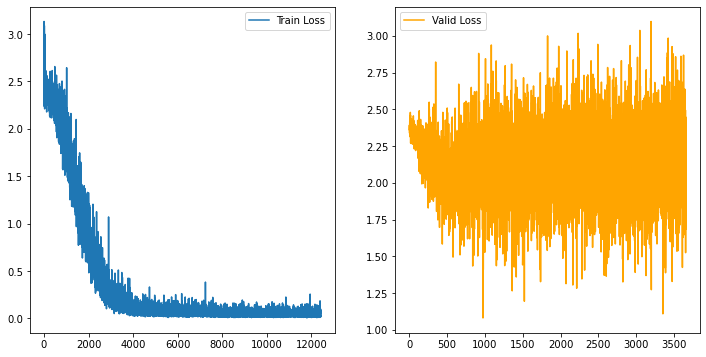

In [31]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
#plt.savefig('CNN_60epochs.png')

In [27]:
def predict(net, loader):
    net.eval()
    pred_lst = []
    true_lst = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long)
            out = net(x)
            _, pred = torch.max(out.data, 1)
            pred_lst.extend(pred.cpu())
            true_lst.extend(y.cpu())
    return pred_lst, true_lst

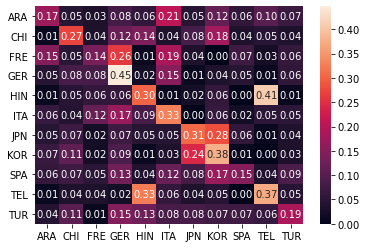

In [28]:
def plot_confusion_mat(net, loader, normalize=True):
    fmt='d'
    pred_lst, true_lst = predict(net, loader)
    cf = confusion_matrix(true_lst, pred_lst)
    if normalize:
        cf = cf / cf.sum(axis=1, keepdims=True)
        fmt='.2f'
    sns.heatmap(cf, annot=True, xticklabels=train_data.categories,
               yticklabels=train_data.categories, fmt=fmt)
    
    return cf

cf_dev = plot_confusion_mat(model, valid_loader, normalize=True)

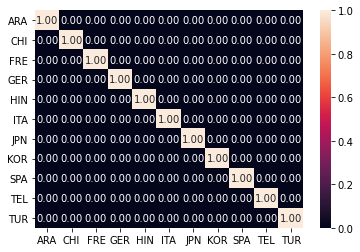

In [29]:
cf_train = plot_confusion_mat(model, train_loader)

In [33]:
def uar(net, loader):
    pred_lst, true_lst = predict(net, loader)
    return recall_score(true_lst, pred_lst, average='macro')
    
train_uar = uar(model, train_loader)
dev_uar = uar(model, valid_loader)
train_uar, dev_uar

(1.0, 0.2782187996493504)

In [34]:
# Save model
torch.save(model.state_dict(), 'CNN_60epochs')

"""
model = CNN(input_shape=(1, 64, 563), batch_size=BATCH_SIZE, 
            num_cats=n_cats).to(device)
model.load_state_dict(torch.load('CNN_60epochs'))
#model.eval()
"""

## Pretrained ResNet34

In [ ]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, n_cats)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [ ]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)